# Oral microbiota before and after toothbrushing

This re-visualizes the oral microbiome dataset used in [Morton and Marotz et al. 2019](https://www.nature.com/articles/s41467-019-10656-5). Just to review, this is a 16S rRNA sequencing dataset spanning 32 samples.

The main goal of this figure is demonstrating the ease of loading multiple layers of differential abundance measurements onto an EMPress tree, allowing us to do things like quickly see how different differential abundance tools agree or disagree.

## Requirements
This should be run from within a QIIME 2 (at least version 2019.10) conda environment, with EMPress installed. Please see [EMPress' README](https://github.com/biocore/empress) for the most up-to-date installation instructions. The final section of this notebook (generating a scatterplot for the supplement) will require matplotlib to be installed -- this should already be included in QIIME 2 conda environments as of writing, but if this changes in the future then you may need to manually install matplotlib.

## 0. Input data files
The data we'll be using comes primarily from [this GitHub repository](https://github.com/knightlab-analyses/reference-frames) containing the Morton/Marotz paper's data.

### 0.1. Downloaded from [the `data/` folder of the reference frames repository](https://github.com/knightlab-analyses/reference-frames/tree/master/data)

- `oral_trimmed_deblur.biom`: Feature table for this dataset. The features described in this table are a subset of the features in `rep-seqs-deblur.qza`, indicating that some filtering was likely done upstream. (This table is not stored as a QIIME 2 artifact, so we don't have provenance data for it.)

- `oral_trimmed_metadata.txt`: Sample metadata for this dataset.

- `deblur-taxonomy.qza`: Taxonomy for this dataset, assigned using q2-feature-classifier's `classify-sklearn` method.

### 0.2. Downloaded from [the `results/oral-results/` folder of the reference frames repository](https://github.com/knightlab-analyses/reference-frames/tree/master/results/oral-results)

(These are the three differential abundance tools' results we'll be visualizing on the tree.)

- `differentials.csv`: Songbird differentials
- `aldex2_results.txt`: ALDEx2 results, including per-feature effect sizes and adjusted p-values
- `ancom_results_mixed.csv`: ANCOM results, including W statistics and whether or not features were significant at certain cutoffs.

### 0.3. Not downloaded from GitHub

- `rep-seqs-deblur.qza`: Sequences for this dataset, produced using Deblur. This artifact was not included in the `reference-frames` GitHub repo, although thanks to QIIME 2's provenance tracking we can verify that this artifact's UUID (`0af26274-7003-4be1-abbf-255c03a6ef9c`) matches the UUID of the sequences from which `deblur-taxonomy.qza` was generated.

For the sake of convenience, we've included all input files in the `notebooks/fig2c/input/` folder within this repository.

## 1. Prepare data

### 1.1. Import feature table
The feature table for this dataset (`fig2c/input/oral_trimmed_deblur.biom`) is just stored as a BIOM table. To use it with QIIME 2, we'll need to "import" it (see the [QIIME 2 docs](https://docs.qiime2.org/2020.8/tutorials/importing/) for details on why this is needed).

In [1]:
!qiime tools import \
    --type "FeatureTable[Frequency]" \
    --input-path fig2c/input/oral_trimmed_deblur.biom \
    --output-path fig2c/output/table.qza

Imported fig2c/input/oral_trimmed_deblur.biom as BIOMV210DirFmt to fig2c/output/table.qza


### 1.2. Load and prepare differential abundance results

First off, we need to convert things so that all of these methods use tab delimiters instead of commas or spaces -- this is because QIIME 2 generally expects all metadata files to be tab-separated.

Also, we'll need to merge all of the differential abundance results into a single DataFrame. It's possible to pass multiple feature metadata files to QIIME 2 and have it do the merging automatically, but currently an "inner join" merge is used -- this can result in a lot of features being dropped if just one of the metadata files only contains entries for some features (see [this issue](https://github.com/biocore/empress/issues/393) for details). For us, this can cause problems because Songbird filters out a few features (although ALDEx2 and ANCOM did not). To get around this, we just do the merging ourselves.

#### 1.2.1. Songbird
See [here](https://github.com/knightlab-analyses/reference-frames/blob/master/scripts/oral-multinomial.sh) for the script that was presumably used to generate these results.

In [30]:
import pandas as pd

sb = pd.read_csv("fig2c/input/differentials.csv", sep=",", index_col=0)

sb.head()

,Intercept,C(brushing_event)[T.before]
99647b51f775c8ddde8ed36a7d60dbcd,4.353183,1.105140
51121722488d0c3da1388d1b117cd239,4.564780,0.797395
d599ebe277afb0dfd4ad3c2176afc50e,3.638733,0.466282
39c4199fe81f30a5b4b0fd5bf2f43c03,3.567794,-0.036673
4629fbb5dde5f8ee07c2259d2887a8d4,2.803713,0.326921


#### 1.2.2. ALDEx2

See [here](https://github.com/knightlab-analyses/reference-frames/blob/master/scripts/aldex2_oral_analysis.R) for the script that was presumably used to generate these results.

In [31]:
aldex2 = pd.read_csv("fig2c/input/aldex2_results.txt", sep=" ", index_col=1)
# Many of the feature IDs erroneously start with X -- this is due to R, see
# https://stackoverflow.com/a/10444744/10730311. To get around this, we remove all leading Xs
# (this is safe because all of the feature IDs seem to have only lowercase alphabetical characters,
# so the only instances of Xs should be at the start of the IDs)
aldex2.index = [i if i[0] != 'X' else i[1:] for i in aldex2.index]
aldex2.head()

,sfit.category,sfit.effect,sfit.padj
99647b51f775c8ddde8ed36a7d60dbcd,1,0.853597,0.132165
51121722488d0c3da1388d1b117cd239,2,0.599897,0.448483
d599ebe277afb0dfd4ad3c2176afc50e,3,0.185457,0.859527
39c4199fe81f30a5b4b0fd5bf2f43c03,4,0.234499,0.927057
4629fbb5dde5f8ee07c2259d2887a8d4,5,0.235738,0.892176


#### 1.2.3. ANCOM

See [here](https://github.com/knightlab-analyses/reference-frames/blob/master/scripts/ancom_oral_analysis.R) for the script that was presumably used to generate these results.

In [32]:
ancom = pd.read_csv("fig2c/input/ancom_results_mixed.csv", sep=",", index_col=0)
# Just like with ALDEx2, remove leading Xs
ancom.index = [i if i[0] != 'X' else i[1:] for i in ancom.index]
ancom.head()

,W_stat,detected_0.9,detected_0.8,detected_0.7,detected_0.6
f6eb8537456dde7792eff60c8d1e797c,201,True,True,True,True
1275c8657f3502d2f3d7b0d9ec7e1c78,188,True,True,True,True
a9b4a380d3b76755de55410a3b856df4,187,True,True,True,True
41f67443ce8207be0c0a956c47823417,180,False,True,True,True
99647b51f775c8ddde8ed36a7d60dbcd,179,False,True,True,True


### 1.3. Merge all the differential abundance results, and export the resulting file

In [36]:
diff = pd.concat([sb, aldex2, ancom], axis=1, sort=False)
# This DataFrame's first column doesn't have a name, so we need to give it a valid
# one to prevent QIIME 2 from yelling at us.
diff.index.name = "FeatureID"
diff.to_csv("fig2c/output/merged-diff-abund.tsv", sep="\t")
diff.head()

,Intercept,C(brushing_event)[T.before],sfit.category,sfit.effect,sfit.padj,W_stat,detected_0.9,detected_0.8,detected_0.7,detected_0.6
FeatureID,,,,,,,,,,
99647b51f775c8ddde8ed36a7d60dbcd,4.353183,1.105140,1,0.853597,0.132165,179,False,True,True,True
51121722488d0c3da1388d1b117cd239,4.564780,0.797395,2,0.599897,0.448483,106,False,False,False,False
d599ebe277afb0dfd4ad3c2176afc50e,3.638733,0.466282,3,0.185457,0.859527,0,False,False,False,False
39c4199fe81f30a5b4b0fd5bf2f43c03,3.567794,-0.036673,4,0.234499,0.927057,6,False,False,False,False
4629fbb5dde5f8ee07c2259d2887a8d4,2.803713,0.326921,5,0.235738,0.892176,19,False,False,False,False


### 1.4. Generate a phylogenetic tree from this data

Before we can visualize a tree, we need to have a tree :)

There are many ways we can do this, but here we don't care too much about the details -- we'll just create a _de novo_ tree from the sequences, which is fortunately simple to do using QIIME 2.

It is worth noting that the sequences described in the table are a subset of the sequences contained in `rep-seqs-deblur.qza`, as mentioned earlier. There are two ways to handle this situation (well, aside from making a new table that didn't use filtering, but that would make us regenerate the differential abundance results here):

1. Generate a tree from _all_ of the sequences, regardless of whether or not they are included in the table, and then pass in the table to EMPress. By default, EMPress will shear the tree to just the sequences contained in the table. (This behavior is configurable with the `--p-shear-tree` parameter of `qiime empress community-plot`.)

2. Filter the sequences down to just those in the table, and then generate a tree from _those_ sequences.

Either solution would "work," in the sense that it'd let us visualize the putative relationships between sequences. We'll go ahead and take option number 2, since it seems like the most straightforward way to handle this.

#### 1.4.1. Filter the sequences to just those in the table

In [27]:
!qiime feature-table filter-seqs \
    --i-data fig2c/input/rep-seqs-deblur.qza \
    --i-table fig2c/output/table.qza \
    --o-filtered-data fig2c/output/filtered-rep-seqs.qza

Saved FeatureData[Sequence] to: fig2c/output/filtered-rep-seqs.qza


#### 1.4.2. Generate a _de novo_ tree from these sequences

This command generates a bunch of different outputs, so we just create a new subdirectory (`filtered-denovo-tree/`) within the output directory to store the results in.

Note that this command will generate both an unrooted and a rooted tree. EMPress requires that the input tree is rooted, so we'll visualize the `Phylogeny[Rooted]` tree. (That said, EMPress can still lay out the tree in an unrooted manner.)

In [28]:
!qiime phylogeny align-to-tree-mafft-fasttree \
    --i-sequences fig2c/output/filtered-rep-seqs.qza \
    --output-dir fig2c/output/filtered-denovo-tree/

Saved FeatureData[AlignedSequence] to: fig2c/output/filtered-denovo-tree/alignment.qza
Saved FeatureData[AlignedSequence] to: fig2c/output/filtered-denovo-tree/masked_alignment.qza
Saved Phylogeny[Unrooted] to: fig2c/output/filtered-denovo-tree/tree.qza
Saved Phylogeny[Rooted] to: fig2c/output/filtered-denovo-tree/rooted_tree.qza


## 2. Visualize the prepared data in the context of the tree

Finally!

### 2.1. Generate the visualization using EMPress

#### Why `community-plot`?

We visualize this tree using `qiime empress community-plot`, which takes as input (in addition to the tree and feature metadata) a feature table and sample metadata files.

We don't _need_ to do this -- for Fig. 2(C), we only visualize feature metadata, so we could instead use `qiime empress tree-plot` and avoid providing the feature table and sample metadata to EMPress. However, it can still be useful to pass this data to EMPress if you have it: here, it lets us do fun things like create barplots showing the split between `before`- and `after`- brushing samples for each tip (which we didn't include in the paper for the sake of space, but is still interesting).

In [39]:
!qiime empress community-plot \
    --i-tree fig2c/output/filtered-denovo-tree/rooted_tree.qza \
    --i-feature-table fig2c/output/table.qza \
    --m-sample-metadata-file fig2c/input/oral_trimmed_metadata.txt \
    --m-feature-metadata-file fig2c/input/deblur-taxonomy.qza \
    --m-feature-metadata-file fig2c/output/merged-diff-abund.tsv \
    --o-visualization fig2c/output/tree-viz.qzv

# Alternately:
# !qiime empress tree-plot \
#     --i-tree fig2c/output/filtered-denovo-tree/rooted_tree.qza \
#     --m-feature-metadata-file fig2c/input/deblur-taxonomy.qza \
#     --m-feature-metadata-file fig2c/output/merged-diff-abund.tsv \
#     --o-visualization fig2c/output/tree-viz-just-fm.qzv

Saved Visualization to: fig2c/output/tree-viz.qzv


### 2.2. Interact with EMPress to configure the visualization

#### 2.2.1. Prepare the visualization

The QZV file we just generated can be uploaded to `view.qiime2.org`, or viewed locally using `qiime tools view`. Alternately, [this is a hyperlink](https://view.qiime2.org/visualization/?src=https://raw.githubusercontent.com/knightlab-analyses/empress-analyses/master/notebooks/fig2c/output/tree-viz.qzv) that'll load the version of the visualization located in this respository.

When the visualization loads, you should see something looking like:

![](fig2c/screenshots/dflt_view.png)

This is showing an unrooted layout of the tree (it's zoomed in a bit, so you can zoom out using your computer mouse to see the full tree). First off, use the `Layout` tab to change the layout to Circular, which will show you a rooted representation of the tree. Having the layout be Circular or Rectangular will allow us to draw tip barplots. (Feel free to try out the Rectangular layout instead!)

![](fig2c/screenshots/circ_layout.png)

Next, to make things a bit clearer, let's use the `Feature Metadata Coloring` tab to color the tree by tips' `Level 2` (aka phylum) taxonomy classifications. You'll need to click the `Update` button.

![](fig2c/screenshots/taxcoloring.png)

#### 2.2.2. Draw barplots

Things are looking nice. Now that the tree is using a rooted layout, we can draw barplots.

Open up the `Barplots` tab and click the checkbox marked `Draw barplots?`. An interface will open up that'll let us add barplot layers to the tree.

All of the differential abundance measurements we'll be using are "feature metadata" -- they're defined for the features in the dataset [represented here as tips in the tree], not for the samples in the dataset. So all of these barplot layers will be `Feature Metadata` layers.

##### Songbird

To match Fig. 2(C) in the paper, the innermost layer will show Songbird differentials. Click on `Color by...` and select `C(brushing_event)[T.before]`, the name of the column of Songbird differentials we'll visualize. (See [Songbird's README](https://github.com/biocore/songbird/#3-specifying-a-formula-) for details on what the output column names mean.) For the color map, select `Spectral` (it's listed under Diverging color maps), and then check the new `Continuous values?` checkbox that'll appear below the color map selector. Click `Update` to draw our first barplot layer.

![](fig2c/screenshots/barplot1.png)

Nice! This layer looks a bit thin, so to make it easier to view let's bump up the `Default length` for this layer to 500. (You'll need to click `Update` here, and throughout this walkthrough, in order to re-draw the barplots.)

![](fig2c/screenshots/barplot1.5.png)

Note how there are a few white bars within this layer, even though white isn't in the `Spectral` color map -- this is because these are features Songbird filtered out from the results. One of the reasons we chose `Spectral` for this is that it allows us to visually distinguish these few bars.

##### ALDEx2

Next, click the `Add another layer` button. This'll create an interface which'll let us describe the next layer, which will contain ALDEx2's effect sizes.

This layer can be created the same way as Songbird's layer -- the only difference is you'll need to `Color by...` the `sfit.effect` field (for ALDEx2 effect sizes).

![](fig2c/screenshots/barplot2.png)

It's getting a bit difficult to distinguish the two layers, so let's use the `Add a border around barplot layers?` controls to add a border with length 100 around the layers. This makes things look a bit nicer. (Remember to click `Update` to make the changes here take effect.)

![](fig2c/screenshots/barplot2.5.png)

##### ANCOM

Almost there! Let's add one more layer. This time, we'll color by `W_stat`, and we'll use `Purples` as our color map (since unlike the other two measurements ANCOM's W-statistic doesn't clearly indicate directionality). Remember to check the `Continuous values?` checkbox, and to increase the length to 500.

![](fig2c/screenshots/barplot3.png)

We're finally done!

A full GIF of the process:

![](fig2c/screenshots/full.gif)

## 3. Visualize the same differential abundance data using a scatterplot
Just to demonstrate that Songbird and ALDEx2's results are roughly correlated, and that ANCOM's W-statistic lacks the "directionality" inherent to the other two methods' results.

(Note that more recent versions of ANCOM can generate output that is more similar to these other results, e.g. in fold-change units -- so this figure shouldn't be interpreted as us trying to dunk on ANCOM. It's moreso just saying "hey, this is what the data looks like." The main reason we've used these slightly old results is so we can reuse the data from Morton/Marotz et al. 2019.)

204 features contained in the DataFrame, including features with missing Songbird data.
195 features contained in the DataFrame, after filtering out those features.


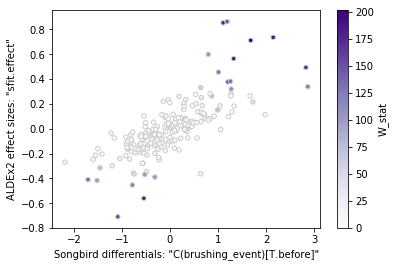

In [72]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
%matplotlib inline

df = pd.read_csv("fig2c/output/merged-diff-abund.tsv", sep="\t", index_col=0)
print("{} features contained in the DataFrame, including features with missing Songbird data.".format(
    len(df.index)
))

# Don't try to plot the features that Songbird filtered out, since we'd be missing data for them
# ... This command works by taking the DataFrame, getting a boolean DF where NaN/Nones/etc. are True and
# everything else is False, transposing that so it's in row (feature)-major order, reducing it to a single
# value for each feature (are there any NaNs within this feature's differential abundance data?), and then
# negating that so we can use it to just select the features that *don't* have any NaNs. Phew!
df = df.loc[~(df.isna().T.any())]

print("{} features contained in the DataFrame, after filtering out those features.".format(len(df.index)))

ax = df.plot.scatter(
    # x-axis: Songbird differentials
    "C(brushing_event)[T.before]",
    # y-axis: ALDEx2 effect sizes
    "sfit.effect",
    # color by ANCOM W-statistics
    c="W_stat",
    # (Use the same color map as in EMPress. There may be slight differences in how EMPress and matplotlib
    # do interpolation, because I haven't really dug into matplotlib's codebase, but the results should be
    # roughly the same.)
    colormap="Purples",
    # Add a light border around points in the scatterplot. The main use of this is that it makes the
    # white points in the middle-ish of the plot much easier to see.
    edgecolors="#cccccc"
)
# Rename labels to be more easily understandable: https://stackoverflow.com/a/31539505/10730311
ax.set_xlabel('Songbird differentials: "C(brushing_event)[T.before]"')
ax.set_ylabel('ALDEx2 effect sizes: "sfit.effect"')

# TODO: rename color bar
pyplot.savefig("fig2c/output/diff-abund-scatterplot.svg")

As we can see, Songbird and ALDEx2's results are pretty similar. ANCOM's W-statistics are pretty low for many of the "middle" features (i.e. the ones in the middle of the plot), and get large for many of the more "extreme" points. This corroborates our interpretation of this information overlaid on a tree in Fig. 2(c): these methods are in rough agreement.